# Making custom plots with matplotlib

By [Terence Parr](https://parrt.cs.usfca.edu). If you like visualization in machine learning, check out my stuff at [explained.ai](https://explained.ai).

The matplotlib library has a lot of capabilities, but there's a lot of customization that you can do above and beyond the basic plotting functionality. You can even create your own kinds of plots by using the drawing and annotation primitives.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches # for drawing shapes

%config InlineBackend.figure_format = 'retina'

In [2]:
df_cars = pd.read_csv("data/cars.csv")

# Get average miles per gallon for each car with the same number of cylinders
avg_mpg = df_cars.groupby('CYL').mean()['MPG']
avg_wgt = df_cars.groupby('CYL').mean()['WGT'] # do the same for average weight

# Get average miles per gallon for each car with the same weight
avg_mpg_per_wgt = df_cars.groupby('WGT').mean()['MPG']

# Get the unique list of cylinders in numerical order
cyl = sorted(df_cars['CYL'].unique())

# Get a list of all mpg values for three specific cylinder sizes
cyl4 = df_cars[df_cars['CYL']==4]['MPG'].values
cyl6 = df_cars[df_cars['CYL']==6]['MPG'].values
cyl8 = df_cars[df_cars['CYL']==8]['MPG'].values

## Annotating graphs with text and lines

Once you've drawn a plot, it's a good idea to go back and annotate it to highlight interesting features.  Let's get the cars data again and redraw the histogram of car weights, but this time let's annotate it.

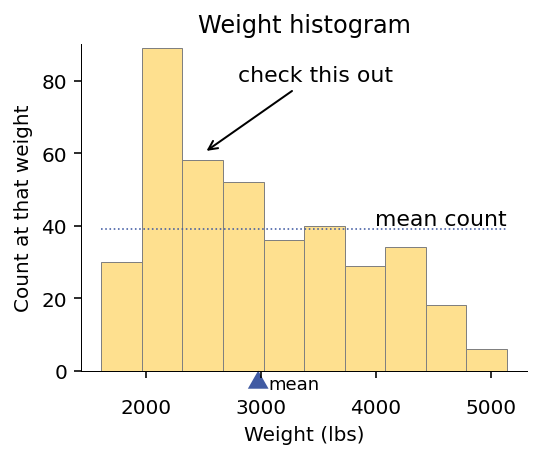

In [16]:
fig, ax = plt.subplots(figsize=(4,3))
wgt = df_cars['WGT']
n, bins, hpatches = ax.hist(wgt, color='#FEE08F')  # save the results of hist
ax.set_xlabel("Weight (lbs)")
ax.set_ylabel("Count at that weight")
ax.set_title("Weight histogram")

# iterate through the rectangles associated with each bar
for rect in hpatches:
    rect.set_linewidth(.5)
    rect.set_edgecolor('grey')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(.5)
ax.spines['bottom'].set_linewidth(.5)

# --------------------------------------------------------------------------------
# New stuff: a horizontal line, and annotated arrow, and a wedge beneath the X axis.
# --------------------------------------------------------------------------------

mx = wgt.mean()
my = np.mean(n)

# Add an arrow with text pointing to something
ax.annotate('check this out', xy=(2500, 60), xytext=(2800, 80),
            arrowprops=dict(color='black',arrowstyle='->'), fontsize=11)
ax.text(max(wgt), my+1, "mean count",
        horizontalalignment='right', fontsize=11)

# Draw a horizontal dashed line at the mean
ax.plot([min(wgt),max(wgt)], [my,my], ':', c='#415BA3', lw=.8)

# Draw a wedge underneath the axis
tria = [(mx,0),(mx+90,-5),(mx-90,-5)]
tria = np.array(tria)
wedge = patches.Polygon(tria, closed=True, facecolor='#415BA3')
wedge.set_clip_on(False) # absolutely critical to drawing outside the graph area
ax.add_patch(wedge)

ax.text(mx+90,-5,"mean",fontsize=9)

ax.tick_params(axis='x', which='major', pad=10) # make room for the wedge
ax.set_ylim(0,90)

plt.show()

### Exercise 1

Add annotations to the following plot to show the intersections. You should maybe also move the legend to the center right as well.

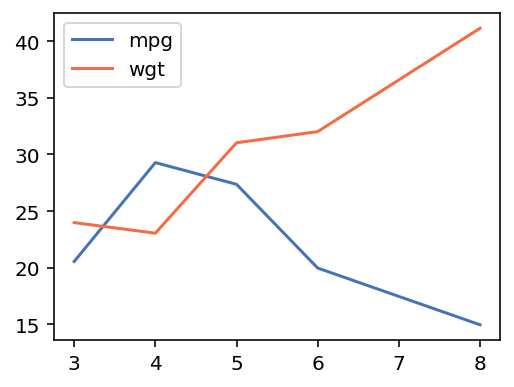

In [18]:
fig, ax = plt.subplots(figsize=(4,3))  # make one subplot (ax) on the figure

ax.plot(cyl, avg_mpg,     c='#4574B4', label="mpg") # Those are 6-digit hexadecimal numbers for red-green-blue
ax.plot(cyl, avg_wgt/100, c='#F46C43', label="wgt")

# ... add annotations here ... 

plt.legend()
plt.show()

Your result might look something like this:<br>

<img src="images/intersection.png" width="250">

## Adding shapes to graphs

Let's say we want to fill a two-dimensional region with different color shapes. To do that, we need to add so-called [Patches](https://matplotlib.org/api/patches_api.html?highlight=patches#module-matplotlib.patches) to the drawing area. We need a new import:

In [5]:
import matplotlib.patches as patches

The basic idea is to create a patch and then add it to the drawing area, `ax`.  We also have to set the X and Y limits because the library does not figure this out from the patches we add.

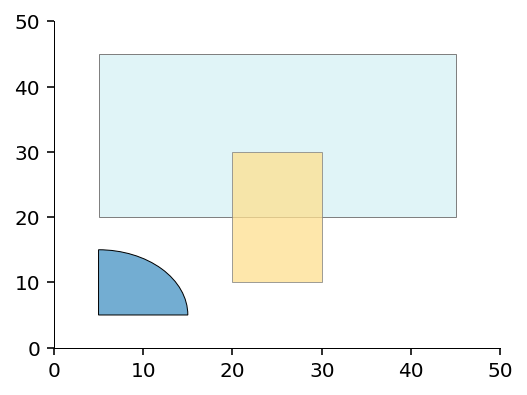

In [19]:
fig, ax = plt.subplots(figsize=(4,3))
ax.set_xlim(0,50)
ax.set_ylim(0,50)

rect = patches.Rectangle(xy=(5,20), width=40, height=25,
                         facecolor='#E0F4F7', linewidth=.5, edgecolor="grey")
ax.add_patch(rect)

rect = patches.Rectangle(xy=(20,10), width=10, height=20, alpha=.75,
                         facecolor='#FEE08F', linewidth=.5, edgecolor="grey")
ax.add_patch(rect)

wedge = patches.Wedge(center=(5,5), r=10, theta1=0, theta2=90,
                      facecolor='#73ADD2', linewidth=.5, edgecolor="black")
ax.add_patch(wedge)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(.5)
ax.spines['bottom'].set_linewidth(.5)

plt.show()

Note: the order in which we add the patches is relevant.  Drawing the orange after the cyan puts the orange one on top. I have set the alpha channel to be slightly transparent on the orange one.

### Exercise 2

Fill in the following code so that it draws rectangles at random locations, with random width and height, and random color. It might look like this:<br>

<img src="images/randrect.png" width="250">

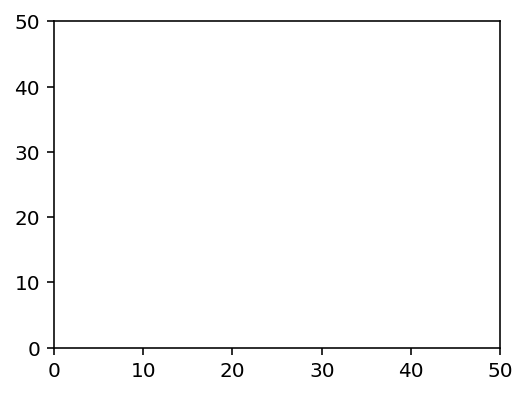

In [7]:
fig, ax = plt.subplots(figsize=(4,3))

size = 50
ax.set_xlim(0,size)
ax.set_ylim(0,size)

n = 5

xy = np.random.rand(n,2) * size
w = np.random.rand(n) * size/2
h = np.random.rand(n) * size/2

# get mapping of n colors in the coolwarm colormap
cmap = plt.get_cmap('coolwarm')
colors=cmap(np.linspace(0,1,num=n)) # get n colors

# ... Draw random rectangles ...

plt.show()

## Strip plots

Box plots are a common mechanism to display information about the distribution of a collection of numbers.  However, the box plot is still showing more or less just point statistics. A violin plot tries to show the shape of the distribution by varying the width.  I actually prefer something called a strip plot, but it is not a standard plot so we have to do it ourselves. The idea is simply to scatterplot all values but add noise to the X or Y values, depending on the orientation. Let's make a vertical strip plot for three series from the cars data set.

If we just plot all of the miles per gallon values for 4, 6, and 8 cylinder cars, we get the following unsatisfying graph. Despite setting the transparency setting, we still don't have a  clear idea about where the density lies along the Y direction.

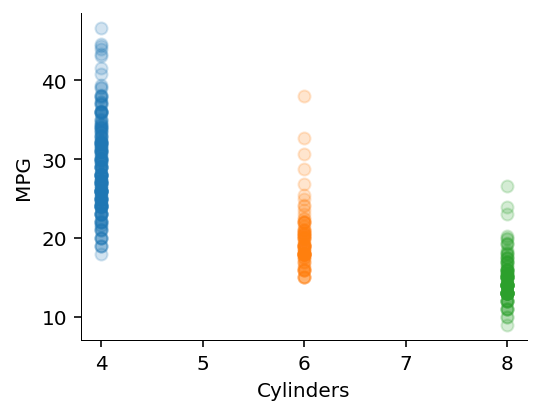

In [8]:
fig, ax = plt.subplots(figsize=(4,3))

n4 = len(cyl4)
n6 = len(cyl6)
n8 = len(cyl8)
ax.scatter([4]*n4, cyl4, alpha=.2)
ax.scatter([6]*n6, cyl6, alpha=.2)
ax.scatter([8]*n8, cyl8, alpha=.2)

ax.set_xlabel("Cylinders")
ax.set_ylabel("MPG")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(.5)
ax.spines['bottom'].set_linewidth(.5)

plt.show()

To fix this, all we have to do now is add some noise to the X coordinate for each point:

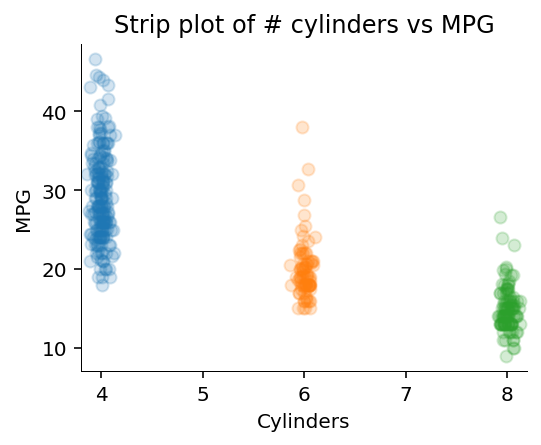

In [21]:
fig, ax = plt.subplots(figsize=(4,3))

n4 = len(cyl4)
n6 = len(cyl6)
n8 = len(cyl8)

sigma = .05
mu = 0
x_noise4 = np.random.normal(mu, sigma, size=n4)
x_noise6 = np.random.normal(mu, sigma, size=n6)
x_noise8 = np.random.normal(mu, sigma, size=n8)

ax.scatter(4+x_noise4, cyl4, alpha=.2) # plot at X=4 plus some noise; Y is same as before
ax.scatter(6+x_noise6, cyl6, alpha=.2)
ax.scatter(8+x_noise8, cyl8, alpha=.2)
pad = 4*sigma
ax.set_xlim(4-pad,8+pad) # leave room for the noisy X coordinates so they don't get clipped

ax.set_xlabel("Cylinders")
ax.set_ylabel("MPG")
ax.set_title("Strip plot of # cylinders vs MPG")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(.5)
ax.spines['bottom'].set_linewidth(.5)
plt.show()

### Exercise 3

Using the same cylinder vs mpg data, create a horizontal strip plot where the number of cylinders is on the vertical axis and the miles per gallon is on the horizontal axis.

## Line + text drawings

There are times when we want something that looks a bit more like an "infographic". As an example, let's look at some world happiness scores and see how they change from 2015 to 2016 (data is in the [data directory](https://github.com/parrt/msds593/tree/master/notebooks/data)):

In [10]:
df_2015 = pd.read_csv("data/happy-2015.csv")
df_2016 = pd.read_csv("data/happy-2016.csv")

In [11]:
df_2015.head(2)

,Country,Region,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,Switzerland,Western Europe,1,7.587,0.03411,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738
1,Iceland,Western Europe,2,7.561,0.04884,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201


In [12]:
countries = ['Finland','Canada','Norway']
countries = ['Syria','Togo','Burundi']
scores = dict()
for c in countries:
    a = df_2015.loc[df_2015['Country']==c, "Happiness Score"].iloc[0]
    b = df_2016.loc[df_2016['Country']==c, "Happiness Score"].iloc[0]
    scores[c] = (a,b)
scores

{'Syria': (3.0060000000000002, 3.069),
 'Togo': (2.839, 3.303),
 'Burundi': (2.905, 2.905)}

Now that we've pulled out the data we want for three countries, let's do some plotting with just lines in text. The axes are a bit tricky to get right.

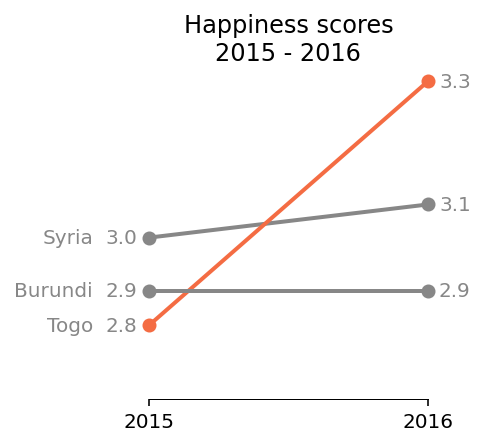

In [13]:
fig, ax = plt.subplots(figsize=(3,3))

# Let's use 0 as the left-hand side and 1 as the right-hand side
# (below we will set labels to 2015 for 0 and 2016 for 1)
ax.set_xlim(0-.1,1+.1)
ax.set_ylim(2.7,3.32)

# Draw lines and text associated with scores
for c in scores:
    a,b = scores[c]
    color = '#878787'
    if c=='Togo':
        color = '#F46C43'
    ax.plot([0,1], [a,b], 'o-', lw=2, c=color)
    ax.text(0-.04, a, f"{a:.1f}", color='#878787',
            horizontalalignment='right', verticalalignment='center')
    ax.text(1+.04, b, f"{b:.1f}", color='#878787',
            horizontalalignment='left', verticalalignment='center')
    ax.text(0-.20, a, c, color='#878787',
            horizontalalignment='right', verticalalignment='center')

# Make the axes look right
ax.set_title("Happiness scores\n2015 - 2016")
ax.spines['bottom'].set_bounds(0, 1)
ax.set_xticks([0,1])
ax.set_xticklabels(['2015','2016'])
ax.set_yticks([])

# Only show the bottom axis
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(.5)
plt.show()